<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task14/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Untuk mengabilkan dataset dari google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


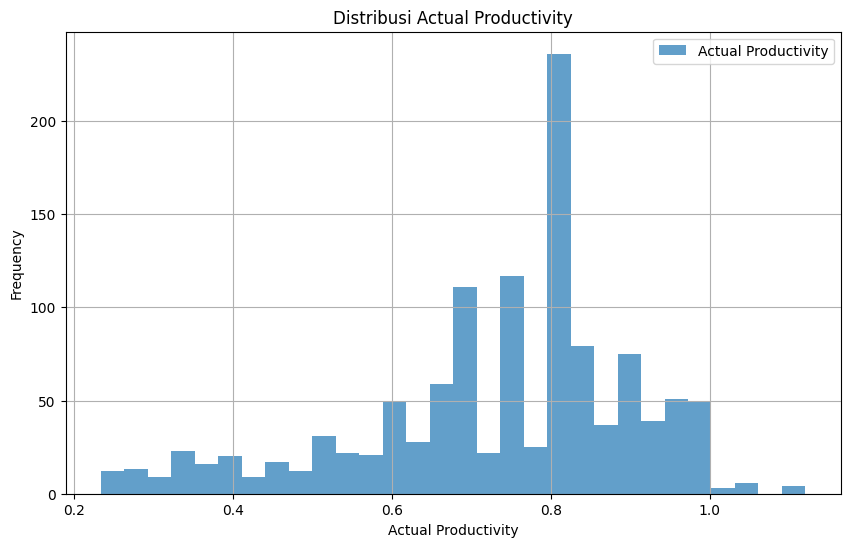

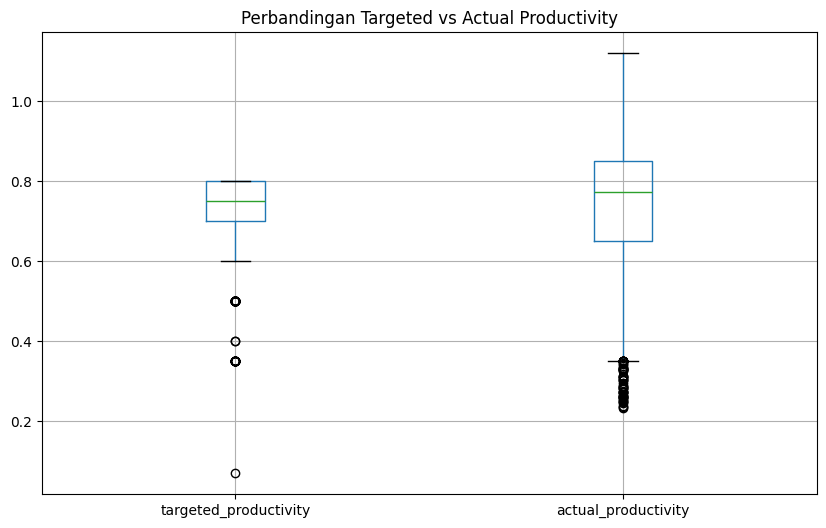

<Figure size 1000x600 with 0 Axes>

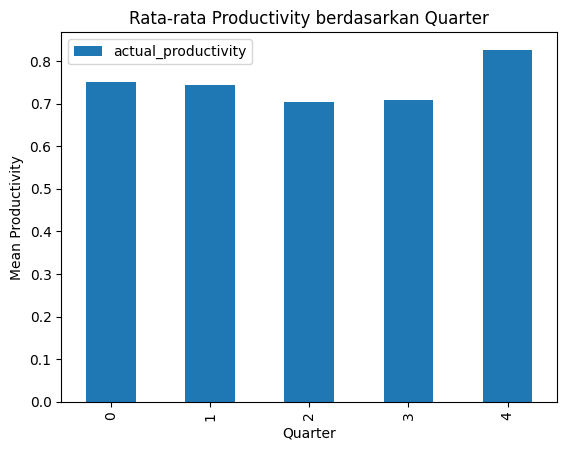


Training: Optimizer=SGD, Hidden Size=32, Deep=False, Epochs=5


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 193/250, Train Loss: 0.0139, Val Loss: 0.0155
Epoch 194/250, Train Loss: 0.0137, Val Loss: 0.0155
Epoch 195/250, Train Loss: 0.0140, Val Loss: 0.0155
Epoch 196/250, Train Loss: 0.0138, Val Loss: 0.0155
Epoch 197/250, Train Loss: 0.0138, Val Loss: 0.0155
Epoch 198/250, Train Loss: 0.0142, Val Loss: 0.0155
Epoch 199/250, Train Loss: 0.0140, Val Loss: 0.0155
Epoch 200/250, Train Loss: 0.0137, Val Loss: 0.0155
Epoch 201/250, Train Loss: 0.0138, Val Loss: 0.0155
Epoch 202/250, Train Loss: 0.0142, Val Loss: 0.0155
Epoch 203/250, Train Loss: 0.0134, Val Loss: 0.0155
Epoch 204/250, Train Loss: 0.0140, Val Loss: 0.0155
Epoch 205/250, Train Loss: 0.0139, Val Loss: 0.0155
Epoch 206/250, Train Loss: 0.0142, Val Loss: 0.0155
Epoch 207/250, Train Loss: 0.0139, Val Loss: 0.0155
Epoch 208/250, Train Loss: 0.0141, Val Loss: 0.0155
Epoch 209/250, Train Loss: 0.0137, Val Loss: 0.0155
Epoch 210/250, Train Loss: 0.0139, Val Loss: 0.0155
Epoch

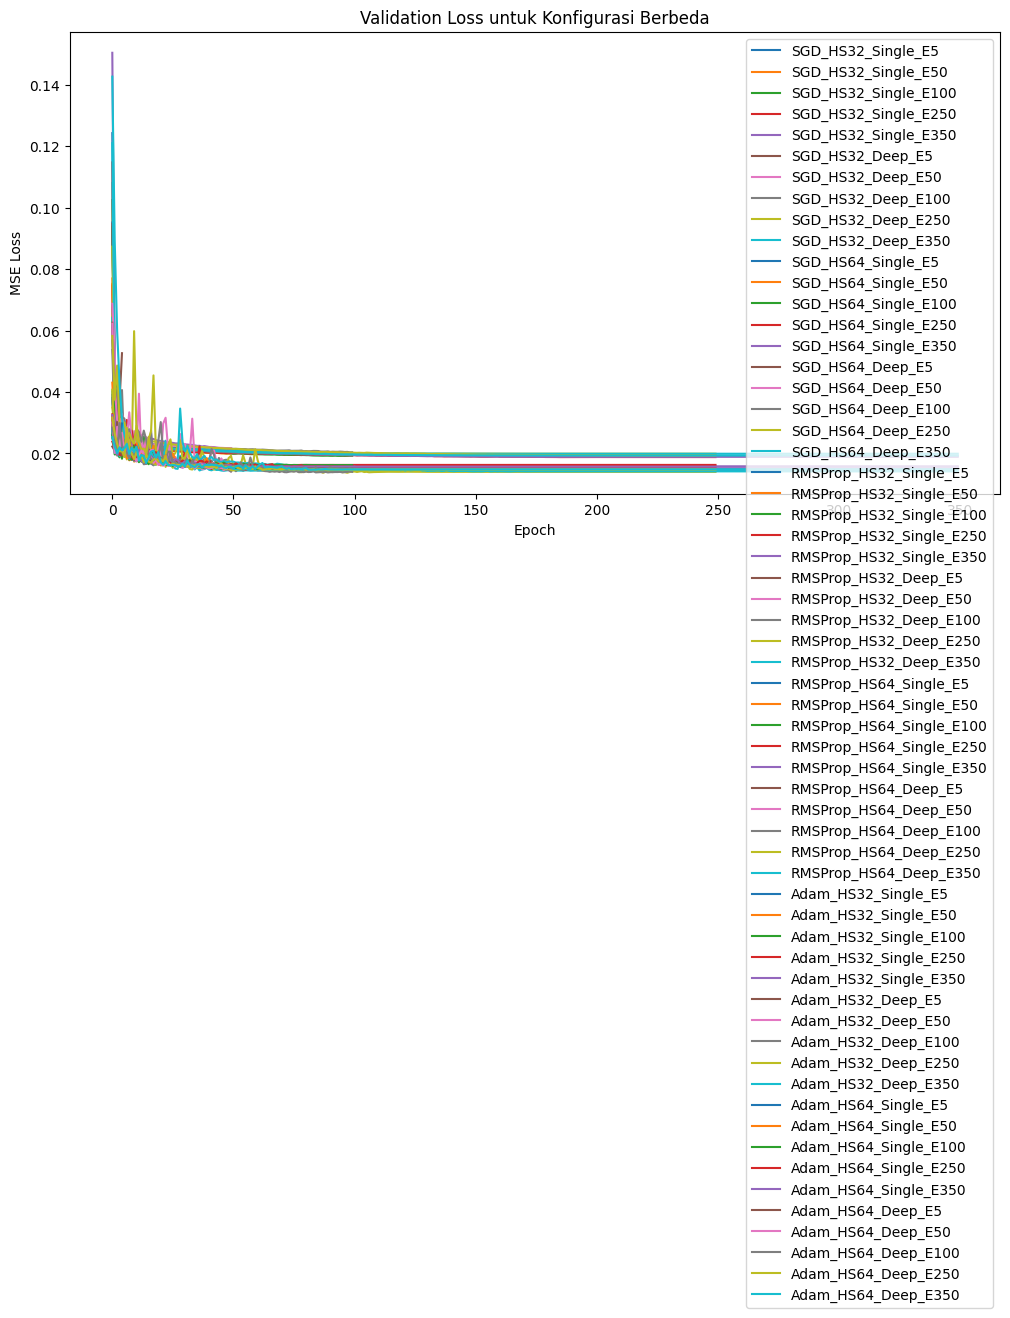

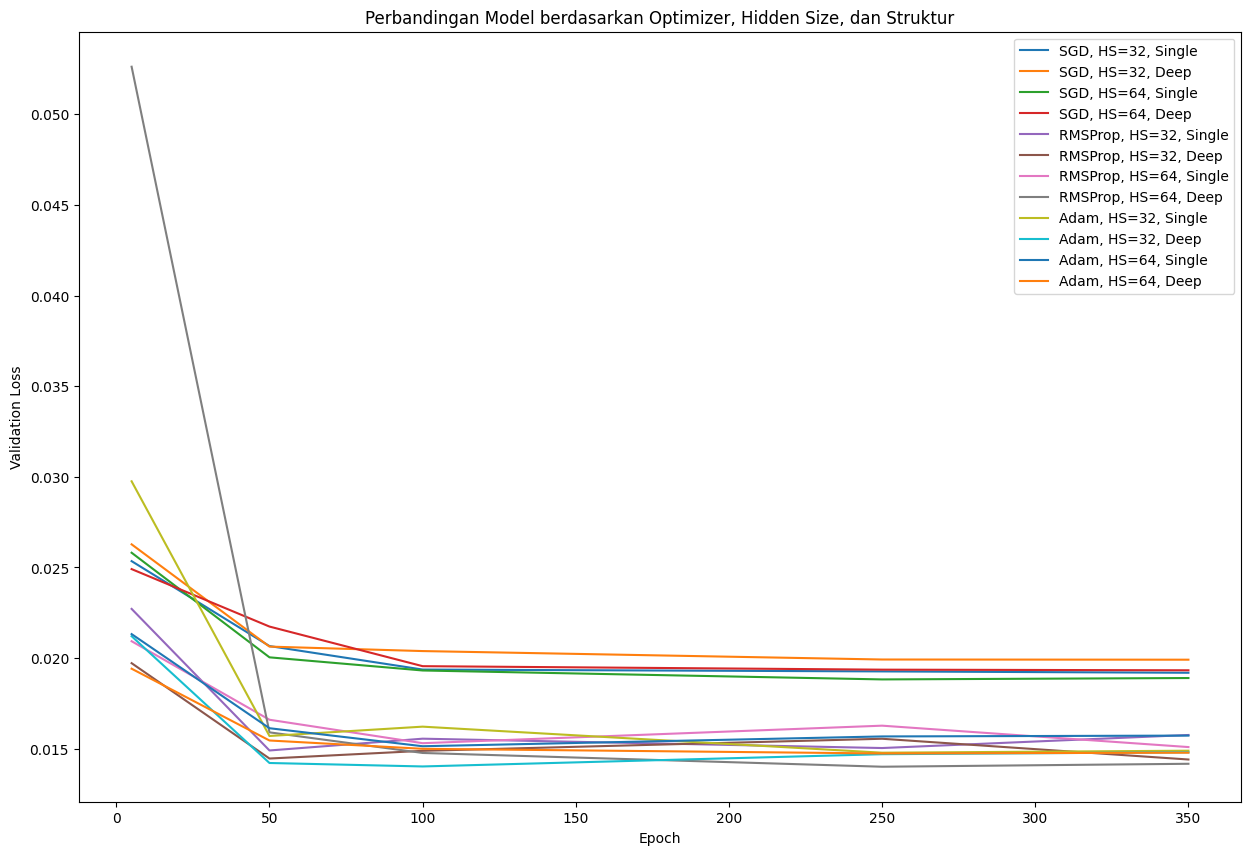


5 Kombinasi Terbaik:
1. RMSProp_HS64_Deep_E250 - Validation Loss: 0.0140
2. Adam_HS32_Deep_E100 - Validation Loss: 0.0140
3. RMSProp_HS64_Deep_E350 - Validation Loss: 0.0142
4. Adam_HS32_Deep_E50 - Validation Loss: 0.0142
5. RMSProp_HS32_Deep_E350 - Validation Loss: 0.0144


In [ ]:
# Import library yang dibutuhkan
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. PRA-PROSES DATA
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/RNN/garments_worker_productivity.csv')

# Tangani nilai yang hilang
data.fillna(data.median(numeric_only=True), inplace=True)

# Encoding kolom kategorikal
categorical_cols = ['quarter', 'department', 'day']
encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col])

# Pisahkan fitur dan target
X = data.drop(columns=['actual_productivity', 'date'])
y = data['actual_productivity']

# Visualisasi awal data
plt.figure(figsize=(10, 6))
data['actual_productivity'].hist(bins=30, alpha=0.7, label='Actual Productivity')
plt.title('Distribusi Actual Productivity')
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/content/drive/MyDrive/RNN/eda_actual_productivity_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
data.boxplot(column=['targeted_productivity', 'actual_productivity'])
plt.title('Perbandingan Targeted vs Actual Productivity')
plt.savefig('/content/drive/MyDrive/RNN/eda_productivity_comparison.png')
plt.show()

plt.figure(figsize=(10, 6))
data[['quarter', 'actual_productivity']].groupby('quarter').mean().plot(kind='bar')
plt.title('Rata-rata Productivity berdasarkan Quarter')
plt.xlabel('Quarter')
plt.ylabel('Mean Productivity')
plt.savefig('/content/drive/MyDrive/RNN/eda_quarter_vs_productivity.png')
plt.show()

# Normalisasi fitur numerik
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data agar sesuai dengan input RNN
X = X.reshape(X.shape[0], 1, X.shape[1])

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi data ke tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Buat DataLoader untuk batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. DEFINISI MODEL
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, is_deep=False):
        super(RNNModel, self).__init__()
        self.is_deep = is_deep
        self.hidden_size = hidden_size

        if self.is_deep:
            # Deep RNN dengan dua lapisan
            self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
            self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        else:
            # Single-layer RNN
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        if self.is_deep:
            out, _ = self.rnn1(x)
            out, _ = self.rnn2(out)
        else:
            out, _ = self.rnn(x)
        out = out[:, -1, :]  # Ambil keluaran terakhir
        return self.fc(out)

# 3. FUNGSI TRAINING DAN EVALUASI

def train_and_evaluate(hidden_size, is_deep, optimizer_name, epochs):
    # Inisialisasi model
    model = RNNModel(input_size=X_train.shape[2], hidden_size=hidden_size, is_deep=is_deep)
    criterion = nn.MSELoss()
    optimizer = {
        'SGD': optim.SGD(model.parameters(), lr=0.01),
        'RMSProp': optim.RMSprop(model.parameters(), lr=0.01),
        'Adam': optim.Adam(model.parameters(), lr=0.01)
    }[optimizer_name]

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    train_losses, val_losses = [], []

    # Loop training
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))

        # Evaluasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_losses.append(val_loss / len(test_loader.dataset))
        scheduler.step(val_losses[-1])  # Update scheduler

        # Output progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# 4. EKSPERIMEN DAN VISUALISASI

results = {}
for optimizer_name in ['SGD', 'RMSProp', 'Adam']:
    for hidden_size in [32, 64]:
        for is_deep in [False, True]:
            for epochs in [5, 50, 100, 250, 350]:
                print(f"\nTraining: Optimizer={optimizer_name}, Hidden Size={hidden_size}, Deep={is_deep}, Epochs={epochs}")
                key = f"{optimizer_name}_HS{hidden_size}_{'Deep' if is_deep else 'Single'}_E{epochs}"
                train_losses, val_losses = train_and_evaluate(hidden_size, is_deep, optimizer_name, epochs)
                results[key] = (train_losses, val_losses)

# Visualisasi hasil
plt.figure(figsize=(12, 6))
for key, (_, val_losses) in results.items():
    plt.plot(val_losses, label=key)
plt.title('Validation Loss untuk Konfigurasi Berbeda')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/RNN/validation_loss_per_config.png')
plt.show()

# Visualisasi perbandingan RNN dan Deep RNN berdasarkan metrik kinerja
metrics = {}
for key, (train_losses, val_losses) in results.items():
    final_val_loss = val_losses[-1]
    metrics[key] = final_val_loss

# Plot perbandingan berdasarkan optimizer
optimizers = ['SGD', 'RMSProp', 'Adam']
hidden_sizes = [32, 64]
is_deeps = [False, True]
epochs_list = [5, 50, 100, 250, 350]

plt.figure(figsize=(15, 10))
for optimizer_name in optimizers:
    for hidden_size in hidden_sizes:
        for is_deep in is_deeps:
            val_losses_by_epoch = [metrics[f"{optimizer_name}_HS{hidden_size}_{'Deep' if is_deep else 'Single'}_E{epochs}"] for epochs in epochs_list]
            plt.plot(epochs_list, val_losses_by_epoch, label=f"{optimizer_name}, HS={hidden_size}, {'Deep' if is_deep else 'Single'}")

plt.title('Perbandingan Model berdasarkan Optimizer, Hidden Size, dan Struktur')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/RNN/model_comparison.png')
plt.show()

# Menampilkan 5 kombinasi terbaik berdasarkan Validation Loss
sorted_metrics = sorted(metrics.items(), key=lambda x: x[1])[:5]
print("\n5 Kombinasi Terbaik:")
for i, (key, val_loss) in enumerate(sorted_metrics, 1):
    print(f"{i}. {key} - Validation Loss: {val_loss:.4f}")
